# Predição de Treineiros para o Enem 2016

Desafio da 9 semana do AceleraDev da Codenation, com o objetivo de predizer os candidatos que fizeram o enem 2016 como treineiros.

## Importando Bibliotecas e Dados

In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.columns

Index(['Unnamed: 0', 'NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA',
       'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA',
       'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL',
       ...
       'Q041', 'Q042', 'Q043', 'Q044', 'Q045', 'Q046', 'Q047', 'Q048', 'Q049',
       'Q050'],
      dtype='object', length=167)

In [6]:
type_columns = pd.DataFrame({
    'Nome': train.columns,
    'Tipos': train.dtypes
})

In [11]:
numericas = train[type_columns[type_columns['Tipos'] != 'object'].index]

In [16]:
numericas #.drop('Unnamed: 0', axis=1, inplace=True)

,NU_ANO,CO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,NU_IDADE,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,TP_ST_CONCLUSAO,...,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041
0,2016,4314902,43,24,0.0,1,1,4314902.0,43.0,1,...,0.0,0.0,5,5,0,5,5,5,5,5.0
1,2016,2304707,23,17,0.0,3,1,2304707.0,23.0,2,...,NaN,NaN,5,5,1,1,1,1,1,NaN
2,2016,2304400,23,21,0.0,3,1,2304400.0,23.0,3,...,NaN,NaN,5,5,5,5,5,5,5,NaN
3,2016,3304557,33,25,0.0,0,1,3304557.0,33.0,1,...,5.0,5.0,5,5,5,5,2,5,5,5.0
4,2016,1302603,13,28,0.0,2,1,1505304.0,15.0,1,...,5.0,4.0,5,5,4,3,1,4,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13725,2016,3502903,35,20,0.0,1,1,3552205.0,35.0,1,...,5.0,5.0,5,5,5,5,5,5,5,NaN
13726,2016,2613800,26,33,0.0,3,2,NaN,NaN,1,...,5.0,4.0,5,5,5,5,5,5,5,NaN
13727,2016,4322186,43,15,0.0,1,1,4303202.0,43.0,3,...,NaN,NaN,5,3,2,2,2,2,2,NaN
13728,2016,3303203,33,36,1.0,3,1,3304557.0,33.0,4,...,5.0,5.0,5,5,2,5,5,3,5,5.0


In [19]:
pca = PCA(n_components=2)

pca.fit(numericas.drop(["IN_TREINEIRO"], axis=1).fillna(0))

numericas_pca = pca.transform(numericas.drop(["IN_TREINEIRO"], axis=1).fillna(0))

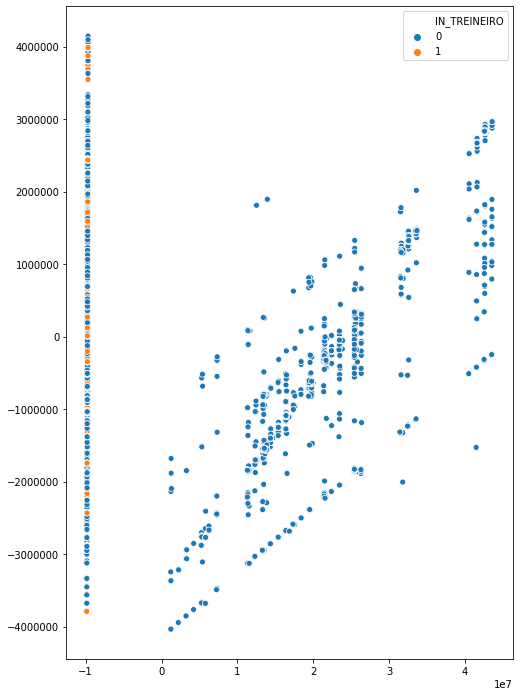

In [41]:
#Vendo se é separavel em duas dimensões
plt.figure(figsize=(8,12))
sns.scatterplot(numericas_pca[:, 0], numericas_pca[:, 1], hue=numericas.IN_TREINEIRO)

## Seleção de atributos e preparação de dados

In [31]:
test.columns

Index(['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE',
       'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC',
       'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA',
       'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO',
       'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
       'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA',
       'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
       'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002',
       'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047'],
      dtype='object')

In [47]:
colunas = ['NU_IDADE','TP_SEXO','TP_ANO_CONCLUIU','NU_NOTA_CN','NU_NOTA_CH',
           'NU_NOTA_LC','NU_NOTA_REDACAO','Q006','Q047','IN_TREINEIRO']

In [49]:
df_train = train[colunas]
colunas.pop()
df_test = test[colunas]

In [51]:
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

/home/capizani/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [79]:
str_columns = ['TP_SEXO', 'Q006', 'Q047']
train_str_encoded = pd.get_dummies(df_train[str_columns])
test_str_encoded = pd.get_dummies(df_test[str_columns])

In [81]:
df_train = pd.concat([df_train, train_str_encoded], axis=1).drop(str_columns, axis=1)
df_test = pd.concat([df_test, test_str_encoded], axis=1).drop(str_columns, axis=1)

In [83]:
smote = SMOTE()

X, y = smote.fit_resample(df_train.drop('IN_TREINEIRO', axis=1),
                                      df_train['IN_TREINEIRO'])

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [141]:
y.value_counts()

1    11947
0    11947
Name: IN_TREINEIRO, dtype: int64

## Escolha do modelo

In [137]:
bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=700, 
                       max_samples=100, bootstrap=True)
randoforest = RandomForestClassifier(n_estimators=700)
adaboost = AdaBoostClassifier(n_estimators=700)
logistic = LogisticRegression()
#knc = KNeighborsClassifier(n_neighbors=7)

In [138]:
models = {"bagging":bagging, "randomforest":randoforest, 
          "adaboost":adaboost, "logistic":logistic}
predictions = pd.DataFrame()

In [139]:
for model in models:
    models[model].fit(X_train, y_train)
    predictions[model] = models[model].predict(X_test)

/home/capizani/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [140]:
predictions['teste'] = y_test.tolist()

In [130]:
predictions

,bagging,randoforest,adaboost,logistic,teste
0,1,1,1,1,1
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,1,0
4,1,1,1,1,1
...,...,...,...,...,...
7164,1,1,1,1,1
7165,1,1,1,1,1
7166,0,0,0,0,0
7167,0,0,0,0,0


In [136]:
reports = {}
for model in models:
    reports[model] = classification_report(predictions['teste'],predictions[model])
    print(model,reports[model])

bagging               precision    recall  f1-score   support

           0       0.95      0.91      0.93      3607
           1       0.91      0.96      0.93      3562

    accuracy                           0.93      7169
   macro avg       0.93      0.93      0.93      7169
weighted avg       0.93      0.93      0.93      7169

randoforest               precision    recall  f1-score   support

           0       0.96      0.95      0.96      3607
           1       0.95      0.96      0.96      3562

    accuracy                           0.96      7169
   macro avg       0.96      0.96      0.96      7169
weighted avg       0.96      0.96      0.96      7169

adaboost               precision    recall  f1-score   support

           0       0.95      0.96      0.95      3607
           1       0.96      0.95      0.95      3562

    accuracy                           0.95      7169
   macro avg       0.95      0.95      0.95      7169
weighted avg       0.95      0.95      0.95  

## Otimização dos Hiperparâmetros

In [146]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 1000, num = 8)]
# Maximum number of levels in tree
max_depth = [None,3,6,9,12]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'random_state': [0],
               'bootstrap': bootstrap}

In [147]:
grid_search = GridSearchCV(estimator = RandomForestClassifier(), 
                           param_grid = param_grid, cv=10, n_jobs=-1, verbose=2)

In [148]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 720 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
/home/capizani/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 49.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 61.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 81.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 108.9min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 145.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 201.9min
[Para

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 3, 6, 9, 12],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [300, 400, 500, 600, 700, 800, 900,
                                          1000],
                         'random_state': [0]},
             verbose=2)

In [152]:
params = grid_search.best_params_

In [153]:
params

{'bootstrap': True,
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800,
 'random_state': 0}

In [156]:
best_randomforest = RandomForestClassifier(n_estimators=params['n_estimators'], 
                                 max_depth=params['max_depth'], 
                                 min_samples_leaf=params['min_samples_leaf'],
                                 min_samples_split=params['min_samples_split'], 
                                 bootstrap=params['bootstrap'], 
                                 random_state=params['random_state'])

In [157]:
best_randomforest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=800, random_state=0)

In [159]:
rfc_pred = best_randomforest.predict(X_test)

In [177]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3607
           1       0.95      0.96      0.96      3562

    accuracy                           0.96      7169
   macro avg       0.96      0.96      0.96      7169
weighted avg       0.96      0.96      0.96      7169



## Salvando predições do melhor modelo

In [162]:
rfc_answer = best_randomforest.predict(df_test)

In [164]:
df_test['IN_TREINEIRO'] = rfc_answer

In [166]:
df_test['NU_INSCRICAO'] = test['NU_INSCRICAO']

In [173]:
df_test['IN_TREINEIRO'].value_counts()

0    3981
1     589
Name: IN_TREINEIRO, dtype: int64

In [175]:
resposta = df_test[['NU_INSCRICAO','IN_TREINEIRO']]
resposta

,NU_INSCRICAO,IN_TREINEIRO
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,0
1,177f281c68fa032aedbd842a745da68490926cd2,0
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,1
3,5c356d810fa57671402502cd0933e5601a2ebf1e,0
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,0
...,...,...
4565,361b7fcd8867119550fe2af5aa729ffad89a7cf5,0
4566,d8a0e4c9e29494cc9bba2422bd79333931475ee1,0
4567,3f1c3388244df8d6521e983a809292d9f3bca643,0
4568,1778e9c4cef591beb6b986d191d15ed05de816b0,0


In [176]:
resposta.to_csv('answer.csv', index=False)